# Train your custom YOLOv5 Visual Inspection model
*Based on and inspired by the  [Yolov5 Tutorials](https://github.com/ultralytics/yolov5/wiki/) by  [Ultralytics](https://ultralytics.com)*

In this notebook we are going to train a custom Yolov5 model for detecting anomalies in images. The data set for this demonstrator is based on the Metal Nut Data Set from mvtec.com

**Metal Nut Data Set**
- Credits to https://www.mvtec.com/company/research/datasets
- See also: https://www.mvtec.com/company/research/datasets/mvtec-ad

**ATTRIBUTION**

Paul Bergmann, Michael Fauser, David Sattlegger, Carsten Steger. MVTec AD - A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection; in: IEEE Conference on Computer Vision and Pattern Recognition (CVPR), June 2019

**LICENSE**

The data is released under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (CC BY-NC-SA 4.0). For using the data in a way that falls under the commercial use clause of the license, please contact us via the form below.

# Setup

Clone GitHub [repository](https://github.com/ultralytics/yolov5), install [dependencies](https://github.com/ultralytics/yolov5/blob/master/requirements.txt) and check PyTorch and GPU.

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 15578, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 15578 (delta 80), reused 112 (delta 56), pack-reused 15393
Receiving objects: 100% (15578/15578), 14.64 MiB | 21.82 MiB/s, done.
Resolving deltas: 100% (10608/10608), done.
/opt/app-root/src/manuela-visual-inspection/ml/pytorch/yolov5

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Install opencv-python-headless many to avoid `ImportError: libGL.so.1: cannot open shared object file: No such file or directory`

In [29]:
!pip install opencv-python-headless


[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-151-g3e14883 Python-3.9.14 torch-2.0.0+cu117 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)


Setup complete ✅ (8 CPUs, 59.9 GB RAM, 54.7/99.5 GB disk)


# Test the setup 

`detect.py` runs YOLOv5 inference on a variety of sources, downloading models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases), and saving results to `runs/detect`. Example inference sources are:

```shell
python detect.py --source 0  # webcam
                          img.jpg  # image 
                          vid.mp4  # video
                          screen  # screenshot
                          path/  # directory
                         'path/*.jpg'  # glob
                         'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                         'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: YOLOv5 requirements "onnx" "onnxruntime" not found, attempting AutoUpdate...

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 48.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 101.5 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 161.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 114.0 MB/s eta 0:00:00
     ━━━━━

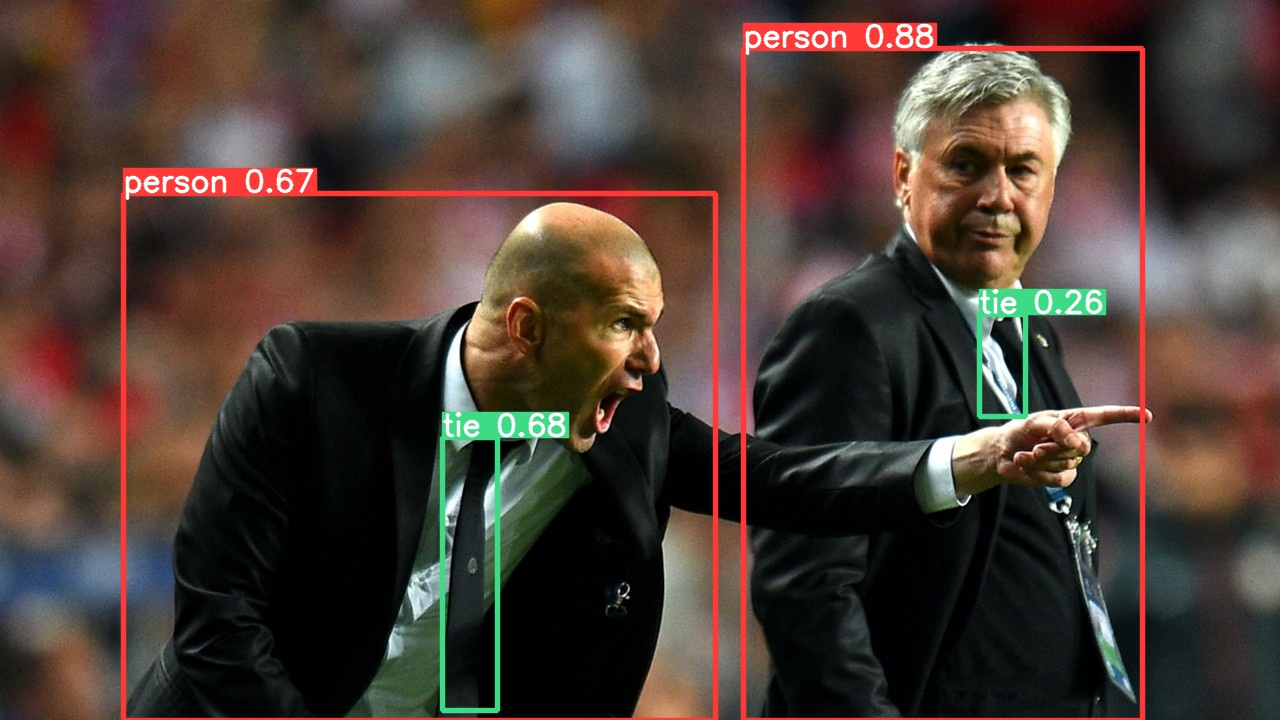

In [4]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images
display.Image(filename='runs/detect/exp/zidane.jpg', width=600)

# Unpack and move the training data


In [27]:
# Unzip the images and annoations
!mkdir -p data/manuela
!unzip  -q -o  ../data.zip -d data/manuela
!ls -l data/manuela/data/*

total 20
-rw-r--r--. 1 1000780000 1000780000  137 Apr 21 09:54 data.yaml
-rw-r--r--. 1 1000780000 1000780000  659 Apr  7 12:17 README.txt
drwxr-sr-x. 4 1000780000 1000780000 4096 Apr  7 12:13 test
drwxr-sr-x. 4 1000780000 1000780000 4096 Apr 23 10:25 train
drwxr-sr-x. 4 1000780000 1000780000 4096 Apr 23 10:25 valid


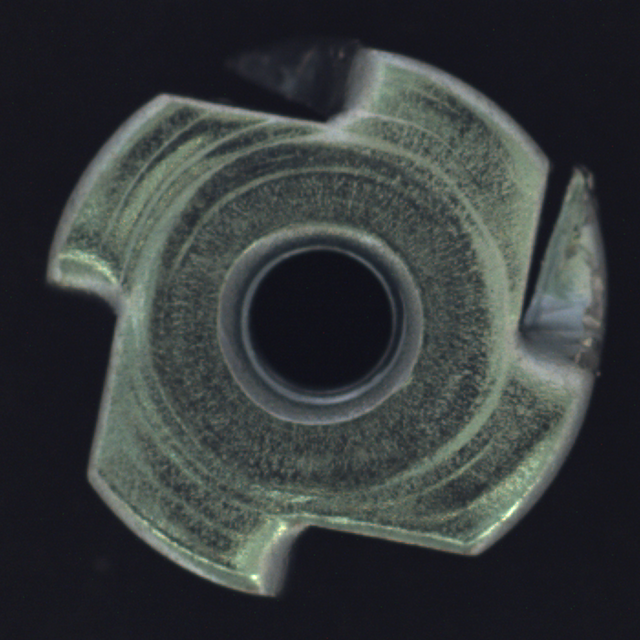

In [6]:
# View image 
display.Image(filename='data/manuela/data/metal-nut-data/valid/images/bent-000.png', width=600)

In [7]:
# Show annotation
!cat data/manuela/data/metal-nut-data/valid/labels/bent-000.txt

1 0.8842857142857142 0.425 0.13714285714285715 0.33285714285714285
1 0.46 0.11857142857142858 0.22 0.13142857142857142


### Start model training 
- `--workers 0` is a workaround for problem with shared memory limit
- Or, extend the share memory for your notebook as describe in the local [README.md](README.md)

In [14]:
!python train.py --img 640 --batch 16 --epochs 600 --data data/metal-nut-data/data.yaml --weights yolov5m.pt --workers 0

train: weights=yolov5m.pt, cfg=, data=data/metal-nut-data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=600, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=0, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-151-g3e14883 Python-3.9.14 torch-2.0.0+cu117 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h

# Test model

In [19]:
!python detect.py --weights runs/train/exp7/weights/best.pt --img 640 --conf 0.25 --source data/manuela/data/metal-nut-data/valid/images/bent-000.png


detect: weights=['runs/train/exp7/weights/best.pt'], source=data/manuela/data/metal-nut-data/valid/images/bent-000.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-151-g3e14883 Python-3.9.14 torch-2.0.0+cu117 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
image 1/1 /opt/app-root/src/manuela-visual-inspection/ml/pytorch/yolov5/data/manuela/data/metal-nut-data/valid/images/bent-000.png: 640x640 2 bents, 11.6ms
Speed: 0.5ms pre-process, 11.6ms inference, 2.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp5


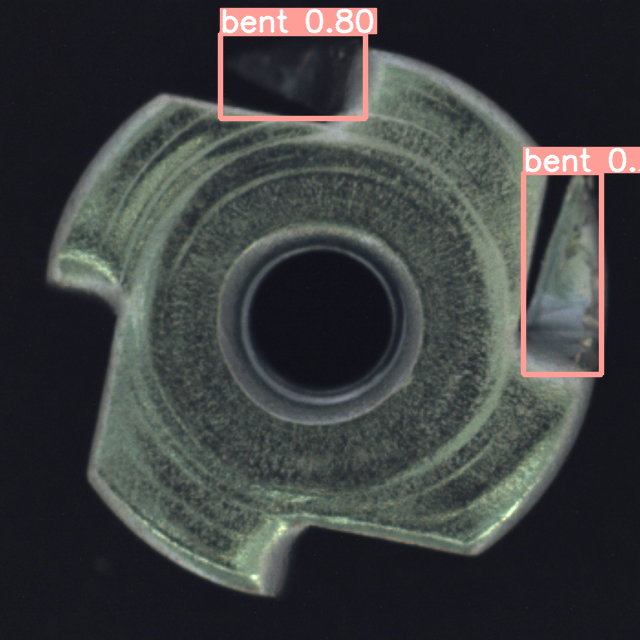

In [20]:
display.Image(filename='runs/detect/exp5/bent-000.png', width=600)

# Export YoloV5 model to ONNX format
Source: [01-yolov5_to_onnx.ipynb](https://github.com/rh-aiservices-bu/yolov5-model-serving/blob/main/01-yolov5_to_onnx.ipynb)
* Eventually modify the image size if you selected  a model with the "6" suffix, as image size is 1280 (and not 640)
* Stay at opset 16 for the moment for OpenVino model server compatibility


In [23]:
!python export.py --weights runs/train/exp7/weights/best.pt --include onnx --imgsz 640 --opset 16

export: data=data/coco128.yaml, weights=['runs/train/exp7/weights/best.pt'], imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=16, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-151-g3e14883 Python-3.9.14 torch-2.0.0+cu117 CPU

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs

PyTorch: starting from runs/train/exp7/weights/best.pt with output shape (1, 25200, 7) (40.3 MB)

ONNX: starting export with onnx 1.13.1...
============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: export success ✅ 2.4s, saved as runs/train/exp7/weights/best.onnx (80.0 MB)

Export complete (4.9s)
Results saved to /opt/app-ro

# Save work into tar file for download

In [28]:
!tar -czvf manu-vi-yolo5-run.tar.gz runs/

runs/
runs/detect/
runs/detect/exp2/
runs/detect/exp2/bent-002.png
runs/detect/exp/
runs/detect/exp/bent-001.png
runs/detect/exp5/
runs/detect/exp5/scratch-001.png
runs/detect/exp4/
runs/detect/exp4/scratch-000.png
runs/detect/exp3/
runs/detect/exp6/
runs/detect/exp6/bent-000.png
runs/train/
runs/train/exp/
runs/train/exp/train_batch2.jpg
runs/train/exp/train_batch0.jpg
runs/train/exp/labels.jpg
runs/train/exp/train_batch1.jpg
runs/train/exp/R_curve.png
runs/train/exp/PR_curve.png
runs/train/exp/F1_curve.png
runs/train/exp/results.csv
runs/train/exp/val_batch0_labels.jpg
runs/train/exp/P_curve.png
runs/train/exp/confusion_matrix.png
runs/train/exp/opt.yaml
runs/train/exp/hyp.yaml
runs/train/exp/labels_correlogram.jpg
runs/train/exp/events.out.tfevents.1680957814.8519c2bd1d4d.1194.0
runs/train/exp/results.png
runs/train/exp/weights/
runs/train/exp/weights/last.pt
runs/train/exp/weights/best.onnx
runs/train/exp/weights/best.pt
runs/train/exp/val_batch0_pred.jpg
